# Investigating the house price on cottage

Imports and set magics:

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
from dataproject import NyboligScraper
from dataproject import NyboligAnalysis


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scraping data

First we need to scrape the data from the internet. The data is scraped from https://www.nybolig.dk/. To know how many pages is possible to scrape you can call the get_pages function of the following property types:

**All**: ''
**Andelsbolig**: 'andelsbolig'
**Ejerlejlighed**: 'ejerlejlighed'
**Sommerhusgrunde**: 'fritidsgrund'
**Grunde**: 'helaarsgrund'
**Hus**: 'hus'
**Landejendomme**: 'landejendom'
**Rækkehuse**:  'raekkehus'
**Sommerhuse**: 'sommerhus'
**Villalejligheder**:   'villalejlighed'


The number of pages that you choose will determine the size of the dataset.

In [83]:
scraper = NyboligScraper()
scraper.get_pages(property_type='sommerhus')


Total number of pages: 212


Next, we need to identify what property types and how many pages we want to work with. To do this you can call the scraper.scrape_data_nybolig(self, num_pages, property_type=None, file_name=None) function. This will save the desired data into a CSV file that we will be able to work with.

In [71]:
scraper.scrape_data_nybolig(num_pages=200, property_type='sommerhus', file_name='dataprojekt_data')

# Accessing Data

Now that we have created the dataset we need to access it. To do this please provide the path of this dictionary with the filename.

In [72]:
file_path = 'dataprojekt_data.csv'
data = pd.read_csv('dataprojekt_data.csv')

print(data.head())



                                    address  postcode              city  \
0              Vandflodvej 25, 6857 Blåvand    6857.0           Blåvand   
1  Drejet 36D, Spodsbj Drej, 5900 Rudkøbing    5900.0         Rudkøbing   
2  Marielyst Strandpark 46, 4873 Væggerløse    4873.0        Væggerløse   
3                     Dillet 7, 4874 Gedser    4874.0            Gedser   
4             Hjelmvej 13, Elsegårde Strand       NaN  Elsegårde Strand   

     price          type  rooms  size_1  size_2  
0  3395000  Fritidsbolig      5     178     NaN  
1  1845000  Fritidsbolig      4      83     NaN  
2  1995000  Fritidsbolig      5     115     NaN  
3  1775000  Fritidsbolig      4      85     NaN  
4  1298000  Fritidsbolig      3      40     NaN  


# Analysis

In [73]:
analysis = NyboligAnalysis(file_path)

To make the analysis more accurate we need to remove outliers from the dataset. We can do this by using the remove_outliers functions from the NyboligAnalysis class. The remove_outliers() function takes two arguments: column_name and threshold. column_name specifies the name of the column that we want to remove outliers from, and threshold specifies the number of standard deviations above or below the mean that we want to consider as outliers.

In [74]:
analysis.remove_outliers('rooms', 15)
analysis.remove_outliers('size_1', 7)

**Descriptive statistics**

Change the list (lst) to perform descriptive statistics on variables of your choosing

In [75]:
lst = ['price', 'rooms', 'size_1']

for i in lst:
    info = analysis.descriptive_statistics(i)
    print(info)
    print()


       count          mean           std     min        25%        50%  \
price   4099  2.329266e+06  2.099233e+06  520000  1250000.0  1795000.0   

             75%       max  
price  2696500.0  32500000  

       count      mean       std  min  25%  50%  75%  max
rooms   4099  3.918517  1.263752    0  3.0  4.0  4.0   14

        count       mean        std  min   25%   50%    75%  max
size_1   4099  91.013906  40.756727    9  64.0  82.0  108.0  401



The dataset consists of 4.099 property samples, providing information on price, number of rooms, and size (in square meters). For the property prices, the average value is approximately 2.329.591 with a standard deviation of 2,099,168. The minimum price is 520.000, and the maximum price is 32,500,000. The 25th percentile is 1,250,000, the median (50th percentile) is 1.795.000, and the 75th percentile is 2.696.500.

In terms of the number of rooms, the average is about 3,92 with a standard deviation of 1,26. The minimum number of rooms is 0, and the maximum is 14. The 25th percentile is 3, the median is 4, and the 75th percentile is also 4.

Regarding the size of the houses (size_1), the average value is 91,01 square meters with a standard deviation of 40,76. The smallest property has 9 square meters, and the largest property has 401 square meters. The 25th percentile is 64 square meters, the median is 82 square meters, and the 75th percentile is 108 square meters.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     1164.
Date:                Sun, 16 Apr 2023   Prob (F-statistic):          8.55e-225
Time:                        19:52:53   Log-Likelihood:                -64973.
No. Observations:                4099   AIC:                         1.299e+05
Df Residuals:                    4097   BIC:                         1.300e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.242e+05   7.08e+04      1.754      0.0

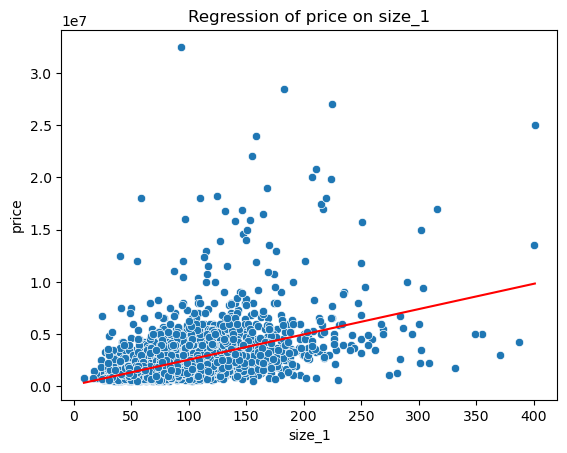

In [76]:
# Define the independent and dependent variables
X = analysis.data[['size_1']]
y = analysis.data['price']

# Fit the OLS model and print the summary
summary = analysis.OLS(X, y)
print(summary)

# Plot the data with the regression line
analysis.plot_regression(X, y)

This OLS regression is performed on the house prices with size (size_1) as the independent variable. The model has an R-squared value of 0,221 and an adjusted R-squared value of 0.221, indicating that approximately 22,1% of the variation in house prices can be explained by the property size. 

The coefficient is 24.220 with a standard error of 710,15, and it is statistically significant (p-value < 0,001). This indicates that for each additional square meter, the house price increases by 24.220 kr. on average.


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     624.6
Date:                Sun, 16 Apr 2023   Prob (F-statistic):          2.01e-128
Time:                        19:52:54   Log-Likelihood:                -65194.
No. Observations:                4099   AIC:                         1.304e+05
Df Residuals:                    4097   BIC:                         1.304e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.813e+04   9.95e+04     -0.383      0.7

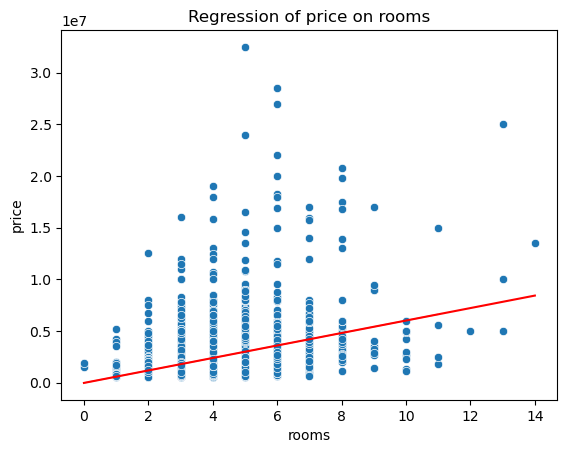

In [77]:
# Define the independent and dependent variables
X = analysis.data[['rooms']]
y = analysis.data['price']

# Fit the OLS model and print the summary
summary = analysis.OLS(X, y)
print(summary)

# Plot the data with the regression line
analysis.plot_regression(X, y)

This OLS regression is performed on the house prices with the number of rooms (rooms) as the independent variable. The model has an R-squared value of 0,132 and an adjusted R-squared value of 0,132, indicating that approximately 13,2% of the variation in house prices can be explained by the number of rooms.

The coefficient is 604.200 with a standard error of 24.200, and it is statistically significant (p-value < 0.001). This indicates that for each additional room, the house price increases by 604.200 kr. on average.


# How does location affect the price?

To see how the location impact the house price we will calculate the average house price of each city. With the intention of visualizing the locations with the cities with the highest prices to the lowest we are creating a bar chart.

In [78]:
# Group the data by city and calculate the mean price
mean_prices_by_city = data.groupby('city')['price'].mean().reset_index()
mean_prices_by_city = mean_prices_by_city.sort_values('price', ascending=False).head(50)


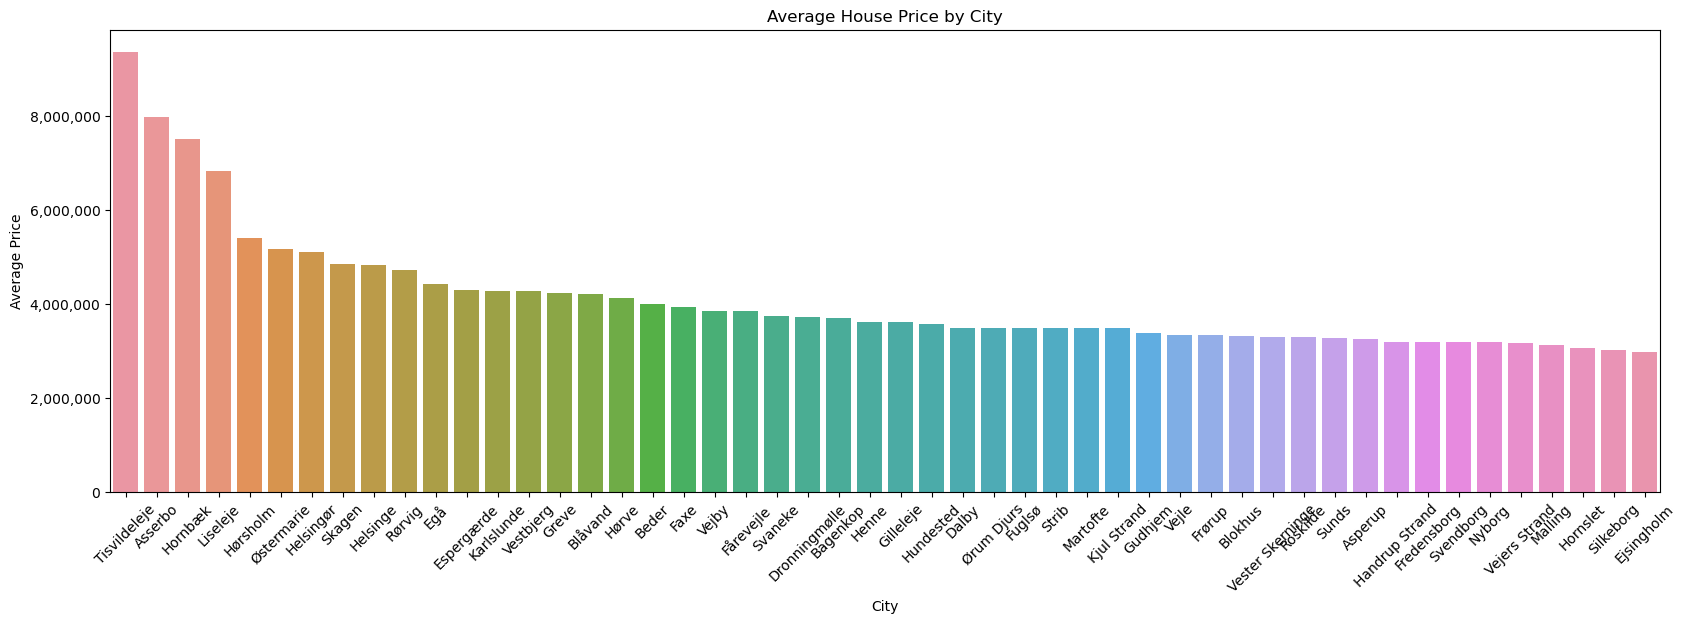

In [79]:
from matplotlib.ticker import FuncFormatter

def price_formatter(x, _):
    return f'{int(x):,}'

formatter = FuncFormatter(price_formatter)

plt.figure(figsize=(20, 6))
ax = sns.barplot(x='city', y='price', data=mean_prices_by_city)
plt.title('Average House Price by City')
plt.xticks(rotation=45)
plt.ylabel('Average Price')
plt.xlabel('City')

ax.yaxis.set_major_formatter(formatter)
plt.show()


We can see from this that the location seems to have a big impact on the houses as the average house price in Tisvilde and Hornbæk is almost twice as high as the cities with the lowest prices.

# Comparing the highest and lowest price city: Hornbæk and Tarm

In our OLS regression we saw that the size of the house is determined to have a positive impact on the price of the house. From our graph on average house prices we saw that Hornbæk and Tarm is considered to have the highest and lowest prices. To look further into this, we want to see if the average house size and rooms in Hornbæk is higher than the houses in Tarm to support our results of the OLS regression. 

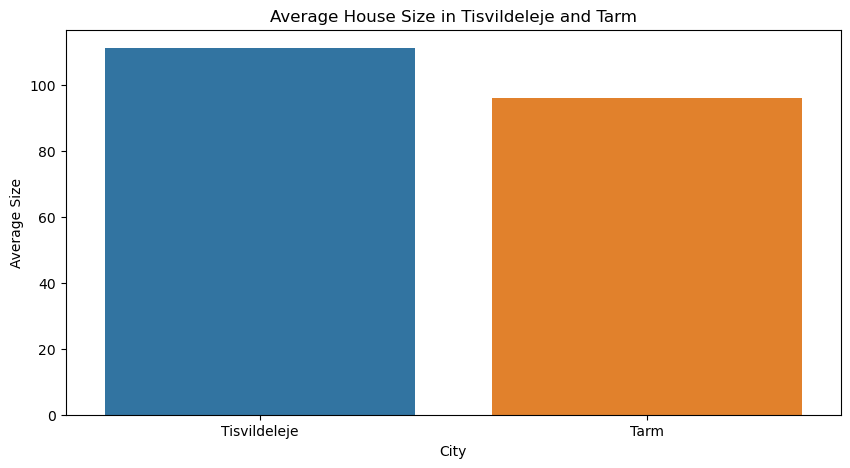

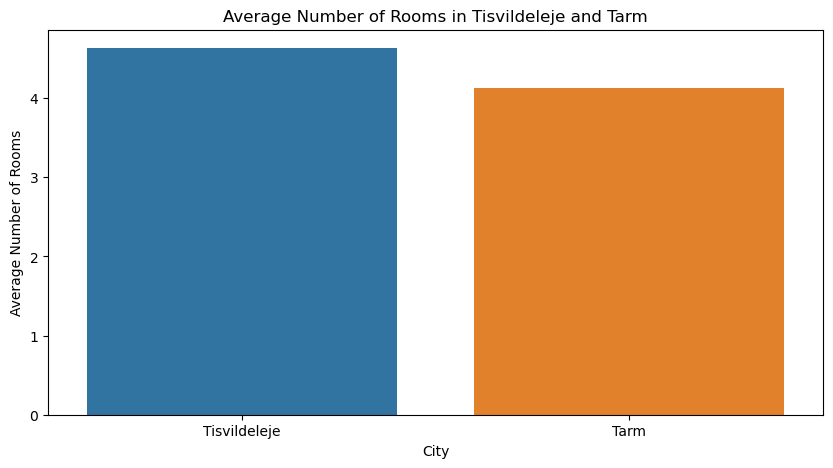

In [80]:
# Filter the dataset for Hornbæk and Tarm 
Tisvildeleje_data = data[data['city'] == 'Tisvildeleje']
tarm_data = data[data['city'] == 'Tarm']


# Calculate the average size and number of rooms for houses in Hornbæk and Tarm
Tisvildeleje_mean_size = Tisvildeleje_data['size_1'].mean()
tarm_mean_size = tarm_data['size_1'].mean()

Tisvildeleje_mean_rooms = Tisvildeleje_data['rooms'].mean()
tarm_mean_rooms = tarm_data['rooms'].mean()

# Visualization
# Create bar charts to compare the average size and number of rooms between houses in Hornbæk and Tarm
# Average size comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=['Tisvildeleje', 'Tarm'], y=[Tisvildeleje_mean_size, tarm_mean_size])
plt.title('Average House Size in Tisvildeleje and Tarm')
plt.ylabel('Average Size')
plt.xlabel('City')
plt.show()

# Average number of rooms comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=['Tisvildeleje', 'Tarm'], y=[Tisvildeleje_mean_rooms, tarm_mean_rooms])
plt.title('Average Number of Rooms in Tisvildeleje and Tarm')
plt.ylabel('Average Number of Rooms')
plt.xlabel('City')
plt.show()

These two graphs shows that the average rooms and size in the houses in Tisvildeleje is higher than in Tarm supporting our OLS regression. 

In our OLS regression we saw that the size of the house is determined to have a positive impact on the price of the house. From our graph on average house prices we saw that Hornbæk and Tarm is considered to have the highest and lowest prices. To look further into this, we want to see if the average house size in Tisvildeleje is higher than the houses in Tarm to support our results of the OLS regression.

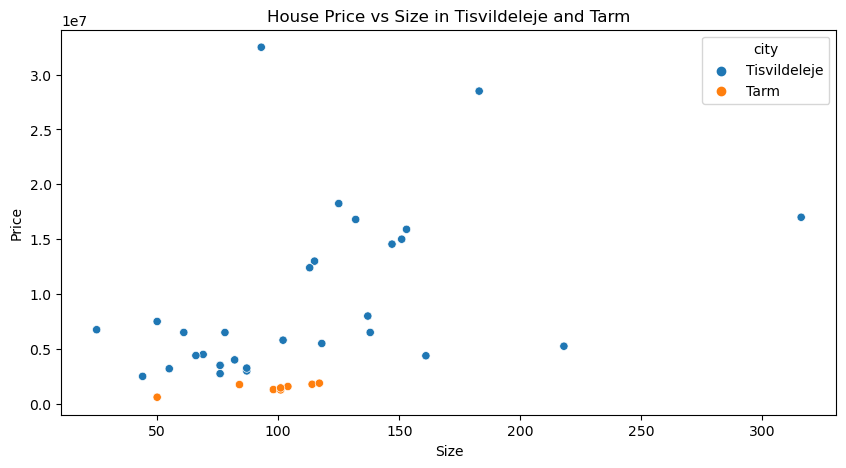

In [81]:
combined_data = pd.concat([Tisvildeleje_data, tarm_data])
plt.figure(figsize=(10, 5))
sns.scatterplot(x='size_1', y='price', hue='city', data=combined_data)
plt.title('House Price vs Size in Tisvildeleje and Tarm')
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()


From this we see that the size of the house does not have a significant big impact on the price of the house in Tarm. On the other hand, the size of the house is considered to have a very significant impact on the price in Hornbæk. There can be several reasons for this. It may be a result of the interest in houses in Tarm is very low why the price may be generally low for all the houses Tarm no matter the size - this is not something we are going to investigate in this assignment, but it is something that would be interesting to look into in another context.